# 탐색

## 라이브러리 호출

In [1]:
import os
import cv2
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

## 데이터셋 지정

In [2]:
data_path = "D:/Dataset/dataset/Aerial_Cactus_Identification/"

labels = pd.read_csv(data_path + "train.csv")
submission = pd.read_csv(data_path + "sample_submission.csv")

In [2]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


### 데이터 비율 확인

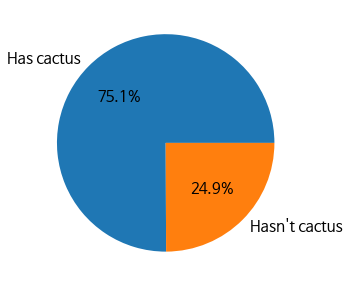

In [3]:
plt.rc("font", size=15)
plt.figure(figsize=(5,5))
label = ["Has cactus", "Hasn\'t cactus" ]
plt.pie(labels["has_cactus"].value_counts(), labels=label, autopct='%.1f%%');

In [4]:
num_train = len(os.listdir(data_path+"train/"))
num_test = len(os.listdir(data_path+"test/"))
print("train_data 개수 : ", num_train)
print("test_data 개수 : ", num_test)

train_data 개수 :  17500
test_data 개수 :  4000


### 데이터 확인

#### Has_cactus

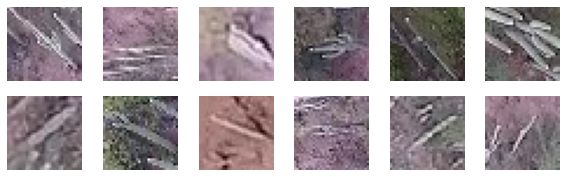

In [5]:
last_has_cactus_img_name = labels[ labels["has_cactus"]==1 ]["id"][-12:]
plt.figure(figsize=(10,3))
for idx, image in enumerate(last_has_cactus_img_name):
    ax = plt.subplot(2,6, idx + 1)
    img_path = data_path+"train/" + image
    images = plt.imread(img_path)
    plt.imshow(images)
    plt.axis("off")

#### Hasn't cactus

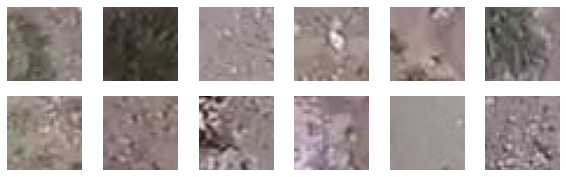

In [6]:
last_hasnt_cactus_img_name = labels[ labels["has_cactus"]==0 ]["id"][-12:]
plt.figure(figsize=(10,3))
for idx, image in enumerate(last_hasnt_cactus_img_name):
    ax = plt.subplot(2,6, idx + 1)
    img_path = data_path+"train/" + image
    images = plt.imread(img_path)
    plt.imshow(images)
    plt.axis("off")

In [8]:
images.shape

(32, 32, 3)

# 베이스라인

## 준비

### 라이브러리 호출

In [41]:
import os
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from skimage import io, color
from torchvision import transforms
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

### 디바이스 설정

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 데이터 path 설정

In [3]:
data_path = "D:/Dataset/dataset/Aerial_Cactus_Identification"

labels = pd.read_csv( os.path.join(data_path,"train.csv") )
submission = pd.read_csv( os.path.join(data_path,"sample_submission.csv") )

In [4]:
labels.tail()

,id,has_cactus
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0
17499,fffd9e9b990eba07c836745d8aef1a3a.jpg,1


In [5]:
train, valid = train_test_split(labels, test_size=0.1, stratify=labels["has_cactus"], random_state=50)
print(len(train), len(valid))

15750 1750


## 데이터 로더

In [30]:
class ImageDataset(Dataset):
    # 생성자
    def __init__(self, df, img_dir="./", transform=None):
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    
    # 데이터셋 크기 반환
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환
    def __getitem__(self,idx):
        img_id = self.df.iloc[idx,0]
        img_path = self.img_dir + img_id
        image = io.imread(img_path)
#         image = color.rgb2lab(rgb) # RBG2LAB
        label = self.df.iloc[idx,1]
        
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [31]:
transform = transforms.ToTensor()

In [32]:
dataset_train = ImageDataset(df=train, img_dir=os.path.join(data_path,"train/"), transform=transform)
dataset_valid = ImageDataset(df=valid, img_dir=os.path.join(data_path,"train/"), transform=transform)

In [33]:
loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

## 모델링

In [34]:
class Model(nn.Module):
    
    # 신경망 계층 정의
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=2)
        self.fc = nn.Linear(in_features=64*4*4, out_features=2)
        
    # 순전파 출력 정의
    def forward(self, x):
        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = self.avg_pool(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        return x

In [35]:
model = Model().to(device)
model

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)

In [36]:
# 손실함수 정의
criterion = nn.CrossEntropyLoss()

In [37]:
# 옵티마이저
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## 훈련

In [39]:
epochs = 10
for epoch in range(epochs):
    epoch_loss = 0 # 매 epochs 마다 loss = 0 으로 초기화
    
    for images, labels in loader_train:
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마지어 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파
        outputs = model(images)
        # loss 계산
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        # 역전파
        loss.backward()
        # 가중치 갱신
        optimizer.step()
        
    # 훈련 데이터 손실값 출력
    print(f"에폭 [{epoch+1}/{epochs} ] - 손실값 {epoch_loss/len(loader_train):.4f}")

에폭 [1/10 ] - 손실값 0.5232
에폭 [2/10 ] - 손실값 0.3557
에폭 [3/10 ] - 손실값 0.2532
에폭 [4/10 ] - 손실값 0.2017
에폭 [5/10 ] - 손실값 0.1815
에폭 [6/10 ] - 손실값 0.1603
에폭 [7/10 ] - 손실값 0.1522
에폭 [8/10 ] - 손실값 0.1438
에폭 [9/10 ] - 손실값 0.1336
에폭 [10/10 ] - 손실값 0.1349


## 성능확인

In [ ]:
true_list = []
preds_list = []

model.eval()

with torch.no_grad(): # 기울기 계산 비 활성화
    for images, labels in loader_valid:
        
        images = images.to(device)
        